# Maternal Health Risk Prediction

## 1. Introduction & Problem Statement
A comprehensive ML project covering classification, regression, feature engineering, and model evaluation to predict the potential of harmful outcomes during pregnancy and childbirth

The dataset used comprises data collected from different hospitals, community clinics, and maternal health care in the rural areas of Bangladesh through the IoT-based risk monitoring system.

In [38]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Data Loading
Loading of the data and initial inspection

In [39]:
# fetch dataset 
maternal_health_risk = fetch_ucirepo(id=863)

# data (as pandas dataframes) 
X = maternal_health_risk.data.features
y = maternal_health_risk.data.targets 

# variable information 
print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeature data types:\n{X.dtypes}")
print(f"\nMissing values:\n{X.isnull().sum()}")
print(f"\nBasic statistics:\n{X.describe()}")

ConnectionError: Error connecting to server

## 3. Exploratory Data Analysis (EDA)

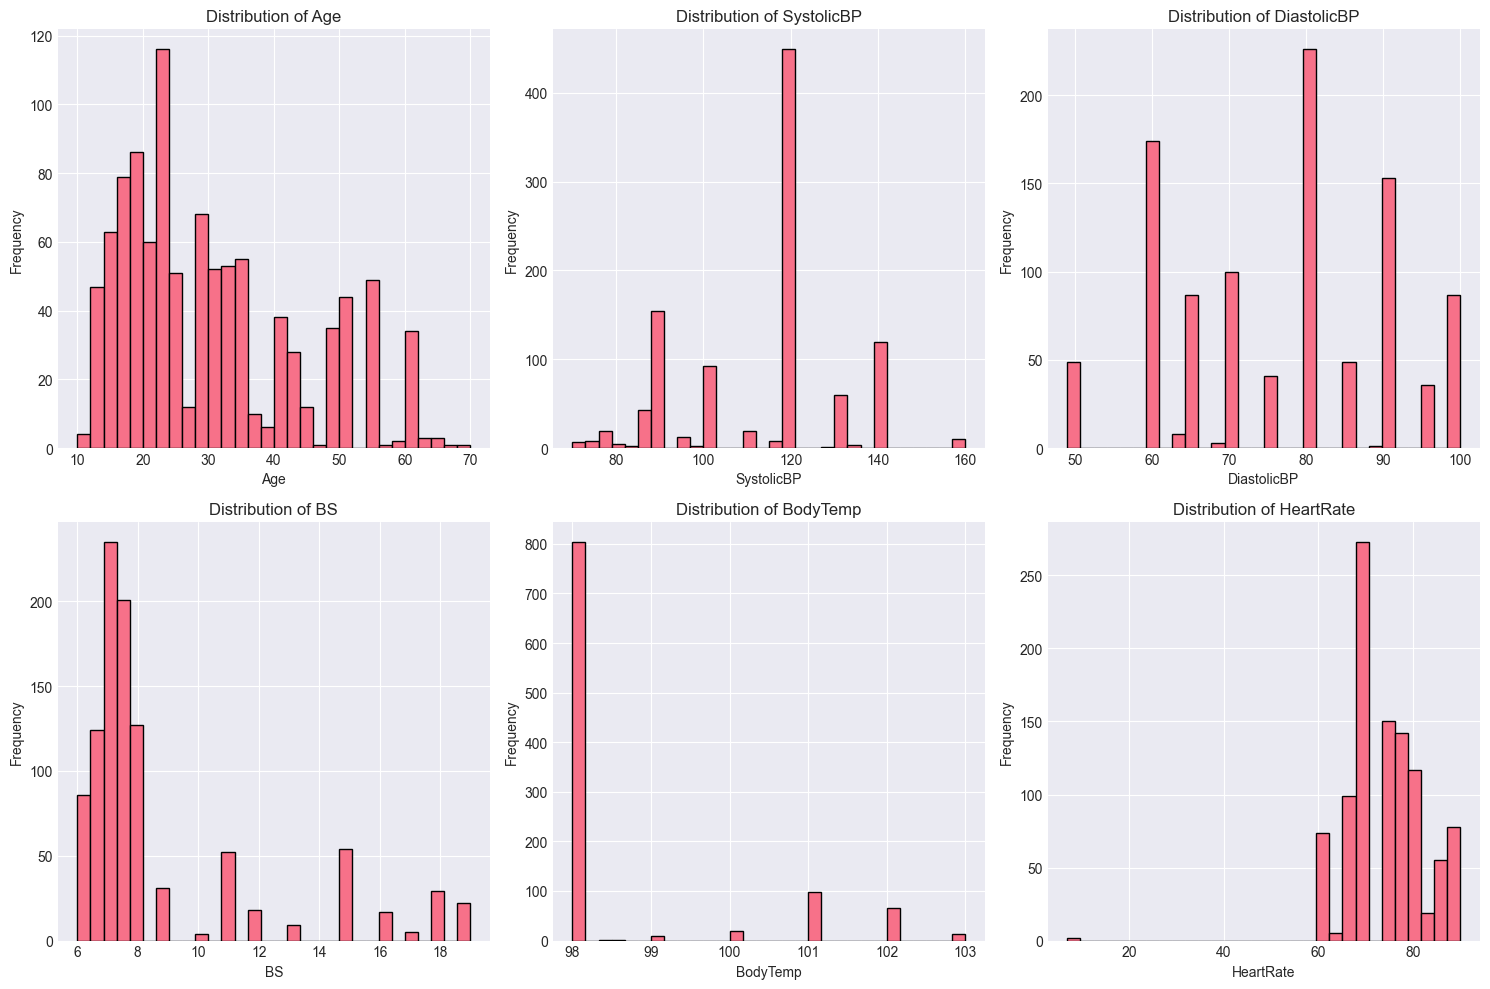

In [3]:
# Distribution of each feature
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, col in enumerate(X.columns):
    ax = axes[idx // 3, idx % 3]
    X[col].hist(bins=30, ax=ax, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

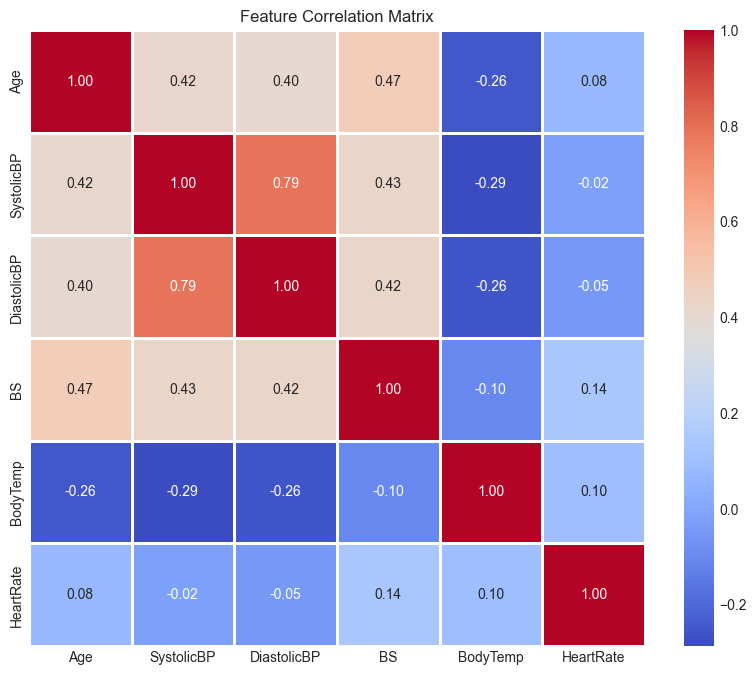

In [4]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1)
plt.title('Feature Correlation Matrix')
plt.show()

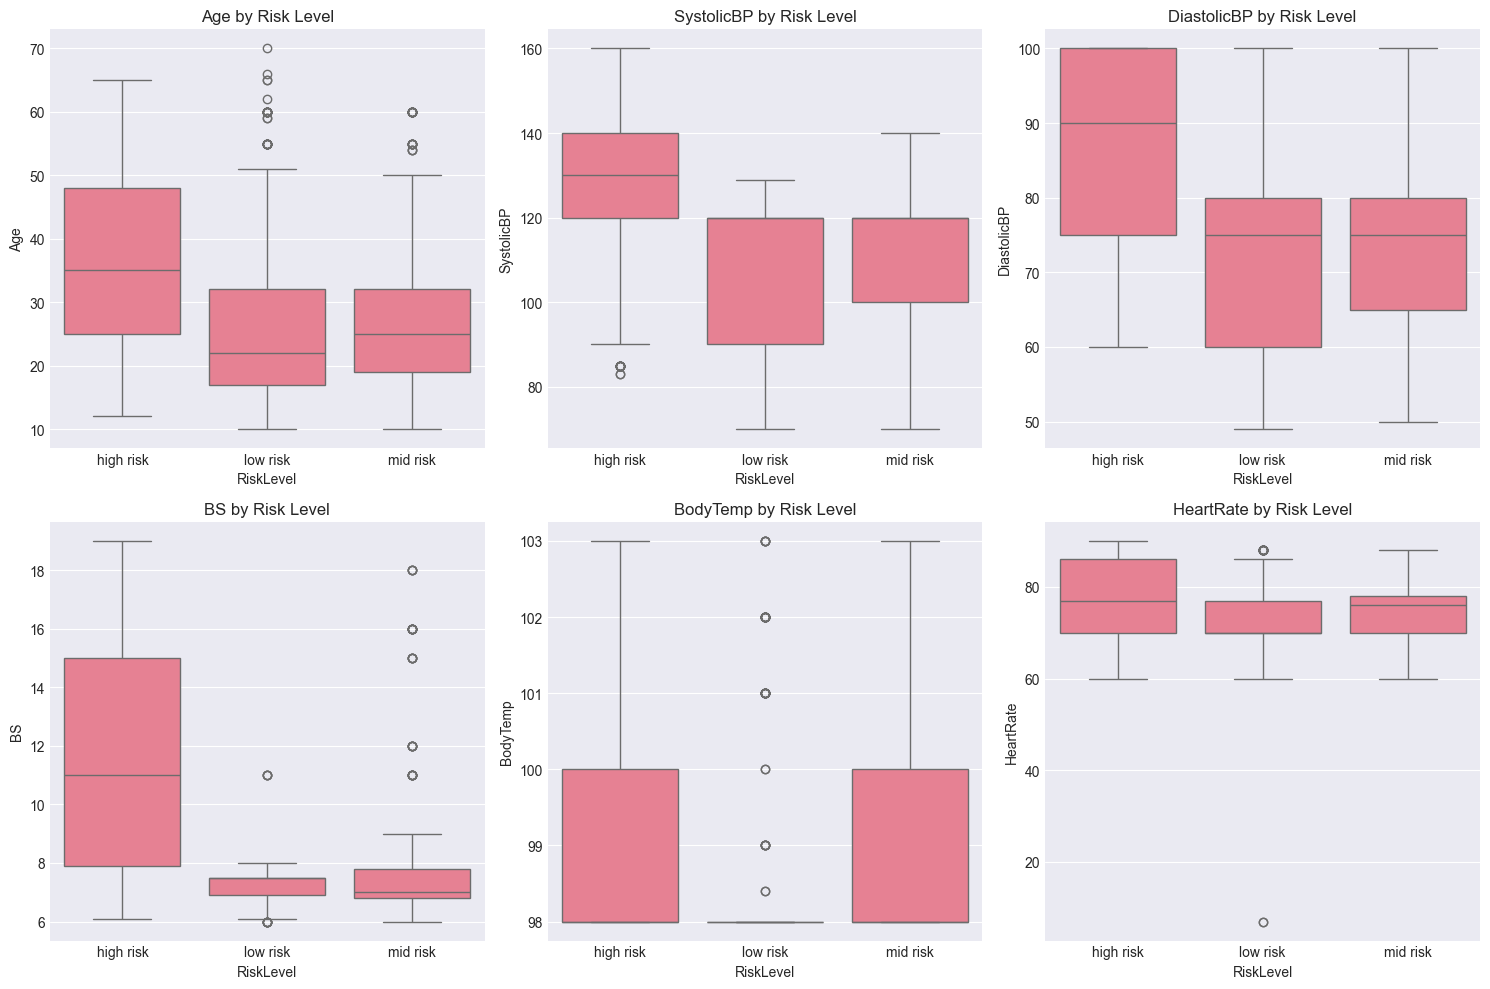

In [47]:
# Box plots for each feature by risk level
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, col in enumerate(X.columns):
    ax = axes[idx // 3, idx % 3]
    sns.boxplot(data=pd.concat([X, y], axis=1), x='RiskLevel', y=col, ax=ax)
    ax.set_title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()

## 4. Data Cleaning

In [5]:
# Check for missing values
print("Missing values per column:")
print(X.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {X.duplicated().sum()}")

# Check for outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

print("\nOutliers per feature:")
for col in X.columns:
    n_outliers = detect_outliers_iqr(X, col)
    print(f"{col}: {n_outliers} outliers")

Missing values per column:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
dtype: int64

Duplicate rows: 598

Outliers per feature:
Age: 1 outliers
SystolicBP: 10 outliers
DiastolicBP: 0 outliers
BS: 210 outliers
BodyTemp: 210 outliers
HeartRate: 2 outliers


In [6]:
## 5. Data Preprocessing

In [7]:
X = maternal_health_risk.data.features
y = maternal_health_risk.data.targets

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

X_train = X_train.reset_index(drop=True)
X_val   = X_val.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

## 6. Feature Engineering & Selection

In [8]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Start with original features
X_engineered = X.copy()

print(f"Original features: {list(X.columns)}")

# Create just 2-3 simple new features
# 1. Pulse Pressure (medical standard feature)
X_engineered['PulsePressure'] = X_engineered['SystolicBP'] - X_engineered['DiastolicBP']

# 2. Mean Arterial Pressure (another medical standard)
X_engineered['MAP'] = X_engineered['DiastolicBP'] + (X_engineered['PulsePressure'] / 3)

print(f"\nNew features created: ['PulsePressure', 'MAP']")
print(f"Total features: {len(X_engineered.columns)}")

FEATURE ENGINEERING
Original features: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

New features created: ['PulsePressure', 'MAP']
Total features: 8


In [9]:
# Split the engineered data
X_full_train_eng, X_test_eng, y_full_train_eng, y_test_eng = train_test_split(
    X_engineered, y_encoded, test_size=0.2, random_state=1
)

X_train_eng, X_val_eng, y_train_eng, y_val_eng = train_test_split(
    X_full_train_eng, y_full_train_eng, test_size=0.25, random_state=1
)

print(f"Training set: {X_train_eng.shape}")
print(f"Validation set: {X_val_eng.shape}")
print(f"Test set: {X_test_eng.shape}")

Training set: (608, 8)
Validation set: (203, 8)
Test set: (203, 8)


In [10]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

# Train Random Forest to get feature importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train_eng, y_train_eng)

# Get importance
importance_df = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))


FEATURE IMPORTANCE

Feature Importance Ranking:
      feature  importance
           BS    0.356034
          Age    0.135159
   SystolicBP    0.119064
          MAP    0.100099
    HeartRate    0.090789
  DiastolicBP    0.073841
PulsePressure    0.067833
     BodyTemp    0.057181


In [11]:
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

# Option 1: Use all features
all_features = list(X_engineered.columns)

# Option 2: Use only features with importance > threshold
threshold = 0.05
important_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

# Option 3: Use original features only
original_features = list(X.columns)

print(f"\nOption 1 - All features: {len(all_features)} features")
print(f"Option 2 - Important features (>{threshold}): {len(important_features)} features")
print(f"Option 3 - Original features only: {len(original_features)} features")

# Choose which to use (default: all features)
selected_features = all_features

print(f"\n✓ Selected: Option 1 ({len(selected_features)} features)")
print(f"Features to use: {selected_features}")


FEATURE SELECTION

Option 1 - All features: 8 features
Option 2 - Important features (>0.05): 8 features
Option 3 - Original features only: 6 features

✓ Selected: Option 1 (8 features)
Features to use: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'PulsePressure', 'MAP']


## 7. Baseline Model

In [12]:
from sklearn.dummy import DummyClassifier

print("="*70)
print("BASELINE MODELS")
print("="*70)

# Dummy Classifier (simplest possible baseline)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_eng[selected_features], y_train_eng)
y_pred_dummy = dummy.predict(X_val_eng[selected_features])
dummy_accuracy = accuracy_score(y_val_eng, y_pred_dummy)

print(f"\n1. Dummy Classifier (always predicts most common class)")
print(f"   Validation Accuracy: {dummy_accuracy:.4f}")

# Logistic Regression Baseline
baseline_lr = LogisticRegression(random_state=42, max_iter=1000)
baseline_lr.fit(X_train_eng[selected_features], y_train_eng)

y_pred_train = baseline_lr.predict(X_train_eng[selected_features])
y_pred_val = baseline_lr.predict(X_val_eng[selected_features])

train_acc = accuracy_score(y_train_eng, y_pred_train)
val_acc = accuracy_score(y_val_eng, y_pred_val)

print(f"\n2. Logistic Regression")
print(f"   Training Accuracy:   {train_acc:.4f}")
print(f"   Validation Accuracy: {val_acc:.4f}")

# Save baseline
baseline_accuracy = val_acc

print("\n" + "="*70)
print(f"BASELINE Accuracy: {baseline_accuracy:.4f}")
print("="*70)


BASELINE MODELS

1. Dummy Classifier (always predicts most common class)
   Validation Accuracy: 0.3645

2. Logistic Regression
   Training Accuracy:   0.6234
   Validation Accuracy: 0.6207

BASELINE Accuracy: 0.6207


## 8. Model Selection

In [15]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_eng[selected_features], y_train)

y_pred_val_rf = rf_model.predict(X_val_eng[selected_features])
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_rf))

Validation Accuracy: 0.8029556650246306


In [18]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_eng[selected_features], y_train)

y_pred_val_xgb = xgb_model.predict(X_val_eng[selected_features])
y_pred_test_xgb = xgb_model.predict(X_train_eng[selected_features])

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_pred_val_xgb))
print("XGBoost Test Accuracy:", accuracy_score(y_train, y_pred_test_xgb))

XGBoost Validation Accuracy: 0.8226600985221675
XGBoost Test Accuracy: 0.9226973684210527


In [22]:
# Create comprehensive comparison
results_comparison = []

# Logistic Regression (best C value)
lr_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
lr_model.fit(X_train_eng[selected_features], y_train)
y_pred_lr = lr_model.predict(X_val_eng[selected_features])

# Random Forest (already trained)
y_pred_rf = rf_model.predict(X_val_eng[selected_features])

# XGBoost (already trained)
y_pred_xgb = xgb_model.predict(X_val_eng[selected_features])

# Compare
models = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb)
]

comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': accuracy_score(y_val, preds)
    }
    for name, preds in models
])

print(comparison_df.to_string(index=False))

              Model  Accuracy
Logistic Regression  0.596059
      Random Forest  0.802956
            XGBoost  0.822660


## 9. Hyperparameter Tuning

In [24]:
def train_and_evaluate(features_to_use):
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_eng[features_to_use], y_train)
    
    # Calculate predictions and accuracy
    y_pred_val = model.predict(X_val_eng[features_to_use])
    y_pred_test = model.predict(X_train_eng[features_to_use])
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred_val)
    return accuracy

results = []
for feature_to_remove in (selected_features):
    # Create feature list without current feature
    features_subset = [f for f in (selected_features) if f != feature_to_remove]
    
    # Train model without this feature
    accuracy_without = train_and_evaluate(features_subset)
    
    # Calculate difference (baseline - without_feature)
    # Positive difference means the feature is useful (accuracy drops without it)
    # Negative difference means the feature is harmful (accuracy improves without it)
    difference = baseline_accuracy - accuracy_without
    
    results.append({
        'feature': feature_to_remove,
        'accuracy_without': accuracy_without,
        'difference': difference
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('difference', ascending=True)
print(results_df.to_string(index=False))
print()
print()
print()
least_useful_feature = results_df.loc[results_df['difference'].abs().idxmin()]
print("Least useful feature (smallest absolute difference):")
print()
print(least_useful_feature)
print(f"\nFeature name: {least_useful_feature['feature']}")
print(f"Difference: {least_useful_feature['difference']}")

      feature  accuracy_without  difference
          Age          0.600985    0.019704
   SystolicBP          0.596059    0.024631
  DiastolicBP          0.596059    0.024631
PulsePressure          0.596059    0.024631
          MAP          0.596059    0.024631
           BS          0.581281    0.039409
     BodyTemp          0.581281    0.039409
    HeartRate          0.581281    0.039409



Least useful feature (smallest absolute difference):

feature                  Age
accuracy_without    0.600985
difference          0.019704
Name: 0, dtype: object

Feature name: Age
Difference: 0.019704433497536922


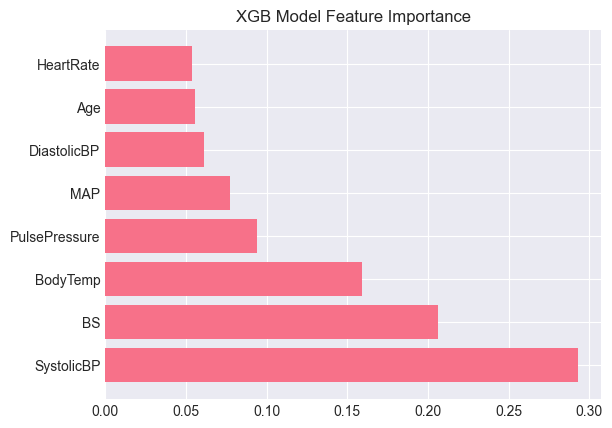

XGBoost Confusion Matrix:
 [[50  4  5]
 [ 1 60 13]
 [ 4  9 57]]

XGBoost Classification Report:
               precision    recall  f1-score   support

   high risk       0.91      0.85      0.88        59
    low risk       0.82      0.81      0.82        74
    mid risk       0.76      0.81      0.79        70

    accuracy                           0.82       203
   macro avg       0.83      0.82      0.83       203
weighted avg       0.83      0.82      0.82       203



In [27]:
importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({'feature': selected_features, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.title("XGB Model Feature Importance")
plt.show()


print("XGBoost Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_val, y_pred_val_xgb, target_names=le.classes_))

## 10. Final Model Evaluation

In [30]:
# Using XGBoost model for final evaluation
final_model = xgb_model 

# Make predictions on test set
y_pred = final_model.predict(X_test_eng)

print("=" * 70)
print("FINAL MODEL EVALUATION")
print("=" * 70)

FINAL MODEL EVALUATION


In [31]:
# 1. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Accuracy: 0.8227 (82.27%)


In [32]:
# 2. Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Mid Risk', 'High Risk']))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Low Risk       0.90      0.89      0.90        63
    Mid Risk       0.84      0.83      0.84        77
   High Risk       0.72      0.75      0.73        63

    accuracy                           0.82       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.82      0.82      0.82       203



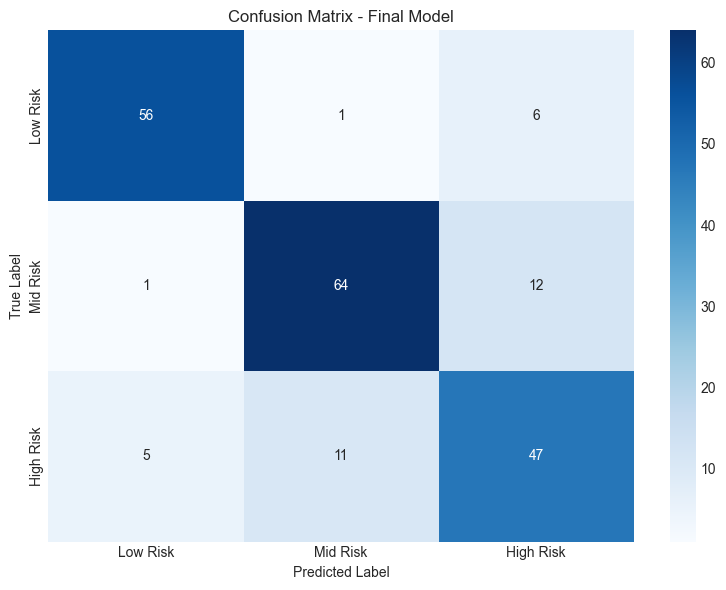

In [33]:
# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk', 'Mid Risk', 'High Risk'],
            yticklabels=['Low Risk', 'Mid Risk', 'High Risk'])
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

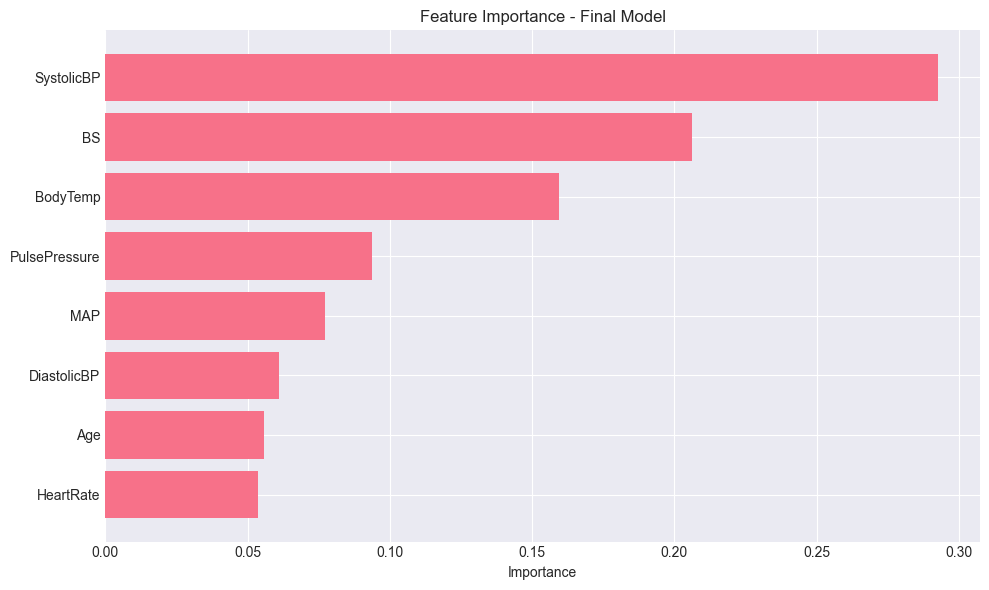


Top 5 Most Important Features:
         feature  importance
1     SystolicBP    0.292835
3             BS    0.206314
4       BodyTemp    0.159327
6  PulsePressure    0.093709
7            MAP    0.077331


In [36]:
# 4. Feature Importance
feature_importance = pd.DataFrame({
    'feature':selected_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Final Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head())